# Mineração de Dados Massivos
## Analise de descrição de mercadorias de Notas Fiscais Eletrônicas

# Ambiente

## Bibliotecas

In [1]:
# Iniciando Ambiente
import numpy as np, pandas as pd, time, random
import datetime as dt

import nltk
from nltk.corpus import stopwords
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

# Se necessário, descomente as linhas a seguir para ler as stopwords
nltk.download('stopwords')
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Módulos

In [2]:
# Módulos de código de programação
#!pip install import-ipynb
import import_ipynb

# Carga de Arquivos
from carga import doCarga

# Tratamento de Dados         
from tratamento import doTratamento


importing Jupyter notebook from carga.ipynb
importing Jupyter notebook from tratamento.ipynb


## Variáveis de Ambiente

In [3]:
# Pasta aonde estão os dados
diretorio = '..\\dados\\'
#diretorio = "F:\\Weisner\\Documentos\\MEGA Estudos\\UNB - MDM - Mineração de Dados Massivos\\Artigo\\" 


In [4]:
# Contador de tempo
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Duração: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

# Carga dos dados

## Abrir arquivo

In [5]:
# Carrega os dados
dfNotas = doCarga(diretorio, opcao=3)
print ("{} registros carregados".format(dfNotas.size))

297438 registros carregados


## Processa se necessário

In [6]:
# doTratamento(dfNotas, diretorio)

In [7]:
# Amostra dos dados
dfNotas

,Remetente,Categoria,NovaDescricao
0,Fornecedor 001,30.0simsim,CACHACA SAO FRANCISCO 12X970M
1,Fornecedor 001,30.0simsim,CACHACA YPIOCA EMP.OURO
2,Fornecedor 001,30.0simsim,CACHACA YPIOCA OURO
3,Fornecedor 001,30.0simsim,CACHACA YPIOCA PRATA
4,Fornecedor 002,30.0simsim,BB CACHACA SAGATIBA PURA (12) GF
...,...,...,...
99995,Fornecedor 047,38.0simnão,SHAMP.INF.BEBE NATUREZA SUAVE
99996,Fornecedor 047,38.0simnão,SHAMP.INF.BEBE NATUREZA SUAVE
99997,Fornecedor 047,38.0simnão,SHAMP.INF.CARROS II MCQUEEN
99998,Fornecedor 047,38.0simnão,SHAMP.INF.CARROS II MCQUEENNC


In [8]:
# Remove a coluna de Remetente
dfNotas = dfNotas.drop(columns=['Remetente'])

# Balanceamento

## Situação - AS-IS

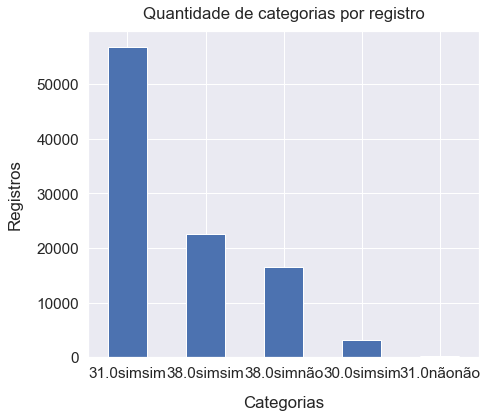

In [9]:
sns.set(font_scale=1.4)
dfNotas['Categoria'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categorias", labelpad=14)
plt.ylabel("Registros", labelpad=14)
plt.title("Quantidade de categorias por registro", y=1.02);
plt.savefig('imagens/DisDesabalanceada.png', bbox_inches='tight');

In [10]:
# Separa os contadores
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4 = dfNotas['Categoria'].value_counts()

In [11]:
# Divide datasets por classes
df_class_0 = dfNotas[dfNotas['Categoria'] == "31.0simsim"]
df_class_1 = dfNotas[dfNotas['Categoria'] == "38.0simsim"]
df_class_2 = dfNotas[dfNotas['Categoria'] == "38.0simnão"] 
df_class_3 = dfNotas[dfNotas['Categoria'] == "30.0simsim"]         # Tamanho escolhido
df_class_4 = dfNotas[dfNotas['Categoria'] == "31.0nãonão"]         # Classse MUITO pequena - UNDERSAMPLING

# Equipara os tamanhos 30.0simsim
# Foram equiparados ao tamanho da classe 3
#MaxSize = df_class_3.size 
MaxSize = 3090 # df_class_3.size 

## Undersampling

In [12]:
# Faz o undersampling a partir de amostras aleatórias
df_class_0 = df_class_0.sample(MaxSize)
df_class_1 = df_class_1.sample(MaxSize)
df_class_2 = df_class_2.sample(MaxSize)

## Oversampling

In [13]:
# Random Oversampling
df_class_4 = df_class_4.sample(MaxSize, replace=True)

## Reagrupa

In [14]:
# Agrupa novamente
dfAjustado = pd.concat([df_class_0, df_class_1, df_class_2, df_class_3, df_class_4], axis=0)

## Resultado - Dataset Balanceado

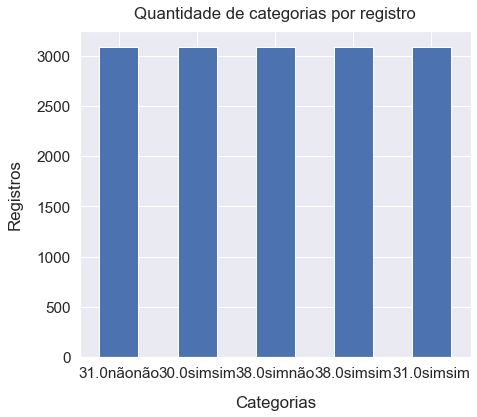

In [15]:
# Gera imagem do balanceamento ajustado
sns.set(font_scale=1.4)
dfAjustado['Categoria'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categorias", labelpad=14)
plt.ylabel("Registros", labelpad=14)
plt.title("Quantidade de categorias por registro", y=1.02);
plt.savefig('imagens/DisBalanceada.png', bbox_inches='tight');  

In [16]:
dfAjustado = dfAjustado.sample(frac=1).reset_index(drop=True)
base_treino = dfAjustado.iloc[:10300,:]
base_teste = dfAjustado.iloc[10301:,:]

#exemplo_base_treino.Categoria.value_counts()
base_teste.shape

(5149, 2)

# Preleção

## StopWords

In [17]:
# Função para retirar as StopWords do Corpus
def removeStopWords(texto, lista_Stop):
    frases = []
    for (palavras, sentimento) in texto:
        # List Comprehension para pegar palavras fora do lista_Stop
        semStop = [ p for p in palavras.split() if p not in lista_Stop]
        frases.append((semStop, sentimento))
    return frases

In [18]:
# StopWords já contempladas na biblioteca NLTK
lista_Stop = nltk.corpus.stopwords.words('portuguese')
#np.transpose(lista_Stop)

In [19]:
# Adicionar StopWord customizada
#lista_Stop.append('Palavra_adicionar')

## Stemming

In [20]:
# Remover sufixos e prefixos das palavras
def aplica_Stemmer(texto):
    global nltk
    global lista_Stop
    nltk.download('rslp')
    stemmer = nltk.stem.RSLPStemmer()
    frases_sem_Stemming = []
    for ( Categoria, NovaDescricao) in texto:
        com_Stemming = [str(stemmer.stem(p)) for p in NovaDescricao.split() if p not in lista_Stop]
        frases_sem_Stemming.append((com_Stemming, Categoria))
    return frases_sem_Stemming

In [21]:
frases_com_Stem_treinamento = aplica_Stemmer(base_treino.values)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [22]:
pd.DataFrame(frases_com_Stem_treinamento, columns=['Categoria', 'Sentimento']).sample(10)

,Categoria,Sentimento
9548,"[aguard, pedr]",30.0simsim
7222,"[credit, icm, s.t., conf., art., 330,, 1., ref...",31.0nãonão
3329,"[vinh, itali, lambrusc, donell]",31.0simsim
6060,"[sc, esmalt, sug, sug]",38.0simsim
1797,"[esm, risqu, bl, natur, rend, tul]",38.0simsim
8735,"[cred, icm, propri, conf., art.330,, 1., ref.j...",31.0nãonão
7014,"[hidram, sh., anti-residu, 4,8l]",38.0simnão
1241,"[cervej, skol, beat, sens, long]",31.0nãonão
9837,"[vin.port.cartux, colheit, tt, 3l, gf]",31.0simsim
3336,"[cervej, skol, beat, secret, long, nec]",31.0nãonão


In [23]:
frases_com_Stem_teste = aplica_Stemmer(base_teste.values)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Ajustes

In [24]:
# Função para retornar apenas as palavras, sem a classificação (sentimento)
def busca_Palavras(frases):
    todas_Palavras = []
    for (palavras, Categoria) in frases:
        todas_Palavras.extend(palavras)
    return todas_Palavras

In [25]:
# Função para verificar a quantidade de vezes que a palavra é mencionada
def busca_frequencia(palavras):
    global nltk
    palavras = nltk.FreqDist(palavras)
    return palavras

In [26]:
palavras_treinamento = busca_Palavras(frases_com_Stem_treinamento)
palavras_teste = busca_Palavras(frases_com_Stem_teste)

In [27]:
print ('Quantidade de palavras no treinamento {}'.format(pd.DataFrame(palavras_treinamento).count()))

Quantidade de palavras no treinamento 0    48039
dtype: int64


In [28]:
frequencia_treinamento = busca_frequencia(palavras_treinamento)

# Análise dos dados de entrada

In [29]:
# Função para retornar somente as palavras únicas
def busca_palavras_unicas(frequencia):
    freq = frequencia.keys()
    return freq

#palavras_unicas_treinamento = busca_palavras_unicas(frequencia_treinamento)
#palavras_unicas_teste = busca_palavras_unicas(frequencia_teste)

In [30]:
# Função para identificar quais palavras únicas estão no documento passo para função
def extrator_palavras(documento):
    global palavras_unicas_treinamento
    doc = set(documento)
    caracteristicas = {}
    for palavras in palavras_unicas_treinamento:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [31]:
# Mesmo anterior, só que dedicada para teste
def extrator_palavras_teste(documento):
    global palavras_unicas_teste
    doc = set(documento)
    caracteristicas = {}
    for palavras in palavras_unicas_teste:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [32]:
# Visualizar quais palavras ocorrem com maior frequência
# Pode ajudar a tunnar a stopwords
frequencia_treinamento.most_common(20)

[('sh', 972),
 ('cachac', 970),
 ('esm', 726),
 ('beb', 480),
 ('kit', 442),
 ('conf', 437),
 ('gf', 384),
 ('aguard', 368),
 ('1.', 327),
 ('cervej', 323),
 ('icm', 317),
 ('nf', 314),
 ('tto', 312),
 ('6x1', 307),
 ('dec', 302),
 ('ressarc', 299),
 ('vinh', 262),
 ('skol', 239),
 ('beat', 234),
 ('bl', 228)]

In [33]:
# Ajustando treinamento
frequencia_teste = busca_frequencia(palavras_teste)

palavras_unicas_treinamento = busca_palavras_unicas(frequencia_treinamento)
palavras_unicas_teste = busca_palavras_unicas(frequencia_teste)

In [34]:
# Faz o preenchimento se tem ou não a característica de acordo com parâmetro
base_completa_treinamento = nltk.classify.apply_features(extrator_palavras, frases_com_Stem_treinamento)
base_completa_teste = nltk.classify.apply_features(extrator_palavras_teste, frases_com_Stem_teste)

# Teste - Naive Bayes

In [35]:
# Treinamento
classificador = nltk.NaiveBayesClassifier.train(base_completa_treinamento)

In [36]:
# Mostra os Labels (Classes)
print(classificador.labels())

['31.0nãonão', '38.0simsim', '31.0simsim', '30.0simsim', '38.0simnão']


In [37]:
# Relação das features mais significativas
print(classificador.show_most_informative_features(10))

Most Informative Features
                      sh = True           38.0si : 38.0si =    384.4 : 1.0
                     6x1 = True           38.0si : 31.0si =    189.6 : 1.0
                      bl = True           38.0si : 38.0si =    152.3 : 1.0
                     our = True           30.0si : 38.0si =    139.4 : 1.0
                      lt = True           31.0nã : 38.0si =    117.0 : 1.0
                     art = True           31.0nã : 30.0si =    111.6 : 1.0
                      v. = True           31.0si : 38.0si =    106.7 : 1.0
                     col = True           38.0si : 30.0si =    102.1 : 1.0
                     can = True           30.0si : 31.0si =     87.7 : 1.0
                    sens = True           31.0nã : 38.0si =     68.2 : 1.0
None


In [38]:
# Acurácia encontrada
print (nltk.classify.accuracy(classificador, base_completa_teste))

0.9708681297339289


## Matriz de Confusão

In [39]:
erros = []
for (frase, Categoria) in base_completa_teste:
    resultado = classificador.classify(frase)
    if resultado != Categoria:
        erros.append((Categoria, resultado, frase))

In [40]:
from nltk.metrics import ConfusionMatrix
esperado = []
previsto = []
for (frase, Categoria) in base_completa_teste:
    resultado = classificador.classify(frase)
    previsto.append(resultado)
    esperado.append(Categoria)

matriz = ConfusionMatrix(esperado, previsto)
print (matriz)

           |    3    3    3    3    3 |
           |    0    1    1    8    8 |
           |    .    .    .    .    . |
           |    0    0    0    0    0 |
           |    s    n    s    s    s |
           |    i    ã    i    i    i |
           |    m    o    m    m    m |
           |    s    n    s    n    s |
           |    i    ã    i    ã    i |
           |    m    o    m    o    m |
-----------+--------------------------+
30.0simsim |<1020>   .    1    .    . |
31.0nãonão |   13<1007>   .    .    . |
31.0simsim |   46    . <985>   3    4 |
38.0simnão |   16    1    2 <998>   9 |
38.0simsim |   16    .    5   34 <989>|
-----------+--------------------------+
(row = reference; col = test)



## Testando o preditor

In [42]:
#teste = 'Bebida láctea chocolate'
#teste = 'amaciante de roupas'
teste = 'sabão em pó'
testeStemming = []
stemmer = nltk.RSLPStemmer()
for (palavras_treinamento) in teste.split():
    comStem = [p for p in palavras_treinamento.split()]
    testeStemming.append(str(stemmer.stem(comStem[0])))

novo = extrator_palavras(testeStemming)

distribuicao = classificador.prob_classify(novo)
for classe in distribuicao.samples():
    print('%s: %f' % (classe, distribuicao.prob(classe)))

31.0nãonão: 0.170913
38.0simsim: 0.088347
31.0simsim: 0.093151
30.0simsim: 0.543246
38.0simnão: 0.104343


# Avaliação

## Executa os treinamentos

In [43]:
tic()
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(base_completa_treinamento)

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(base_completa_treinamento)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(base_completa_treinamento)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(base_completa_treinamento)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(base_completa_treinamento)

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(base_completa_treinamento)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(base_completa_treinamento)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(base_completa_treinamento)

tac()

Duração: 0hour:36min:7sec


## Mede Acurácia

In [44]:
tic()
Resultados = []
Resultados.append((nltk.classify.accuracy(BNB_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(MNB_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(BernoulliNB_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(LogisticRegression_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(SGDClassifier_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(SVC_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(LinearSVC_classifier, base_completa_teste))*100)
Resultados.append((nltk.classify.accuracy(NuSVC_classifier, base_completa_teste))*100)
tac()

Duração: 0hour:25min:44sec


## Apresenta Resultados

In [131]:
Classificadores = []
Classificadores.append('Naive Bayes')
Classificadores.append('MNB')
Classificadores.append('Bernoulli NB')
Classificadores.append('Log Regression')
Classificadores.append('SGD')
Classificadores.append('SVC')
Classificadores.append('Linear SVC')
Classificadores.append('NuSVC')

In [132]:
Coleta = list(zip(Classificadores, Resultados))
dfResultado = pd.DataFrame(Coleta, columns = ['Classificador', 'Acuracia'])

In [133]:
dfResultado

,Classificador,Acuracia
0,Naive Bayes,96.018644
1,MNB,96.814916
2,Bernoulli NB,96.018644
3,Log Regression,97.921927
4,SGD,98.019033
5,SVC,97.844242
6,Linear SVC,97.921927
7,NuSVC,92.561662


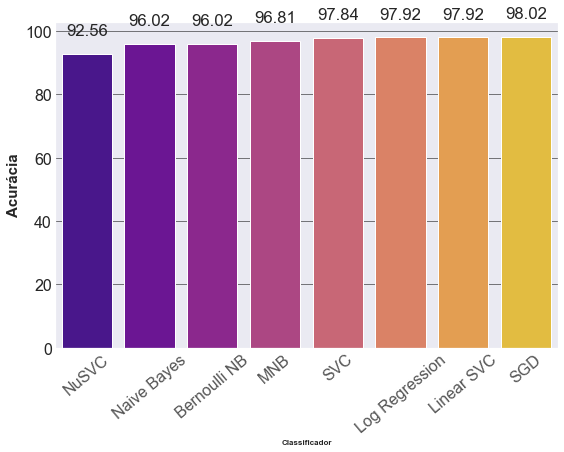

In [153]:
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(x='Classificador',y='Acuracia',
    data=dfResultado, order = dfResultado.sort_values('Acuracia').Classificador,
    palette = 'plasma', color='white', ci=95, ax=ax)
#ax.set_title('Desempenho')
ax.tick_params(labelsize=16,length=0)
#plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)
ax.set_xlabel('Classificador', weight='bold',size=8)
ax.set_ylabel('Acurácia', weight='bold',size=15)

#plt.yticks(np.arange(90, 100, 1)) #yticks starts from 90 and ends at 18, step is 4
# ax.set_yticklabels([' ','$90','$92','$94','$96'], color='#565656')

x_labels = list(dfResultado.sort_values('Acuracia')['Acuracia']) #dfResultado.Acuracia.to_list()
#ax.set_xticklabels(x_labels)


rects = ax.patches

# Make some labels.
labels = ["{:.4}".format(x_labels[i]) for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.xticks(rotation=40, color='#565656')

plt.savefig('imagens/ResultadoFinal.png', bbox_inches='tight');